The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 
- Try AutoAugment/RandAugment
- Add regularization
- Resampling  
  - Make resampling func for unlab_ds
- Create new unlab_ds without previous findings

# Loading data

In [136]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from utils import show_image, class_distribution, print_split_info, unpipe
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some parameters

In [139]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')

conf = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "resample": True,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 123,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 15,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "decay_rate": 0.1,                 # higher number gives steeper dropoff
    "checkpoint": False,
    "early_stopp": True,
    "early_stopp_patience": 6,
    # Misc
    "verbosity": 1
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [140]:
clean_train, train_ds, test_ds, val_ds, params = create_dataset(conf)

class_names = params["class_names"]

barretts-short-segment      :   53 | 0.50%
retroflex-stomach           :  764 | 7.17%
ulcerative-colitis-0-1      :   35 | 0.33%
ulcerative-colitis-grade-3  :  133 | 1.25%
esophagitis-b-d             :  260 | 2.44%
dyed-resection-margins      :  989 | 9.28%
hemorrhoids                 :    6 | 0.06%
normal-z-line               :  932 | 8.74%
esophagitis-a               :  403 | 3.78%
ulcerative-colitis-1-2      :   11 | 0.10%
barretts                    :   41 | 0.38%
bbps-2-3                    : 1148 | 10.77%
ileum                       :    9 | 0.08%
bbps-0-1                    :  646 | 6.06%
impacted-stool              :  131 | 1.23%
cecum                       : 1009 | 9.46%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-2-3      :   28 | 0.26%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-1  :  201 | 1.89%
polyps                      : 1028 | 9.64%
dyed-lifted-polyps          : 1002 | 9.40%

Total num

In [4]:
datasets = {"train": train_ds.unbatch().take(params["train_size"]),
            "test": test_ds.unbatch().take(params["test_size"]),
            "val": val_ds.unbatch().take(params["val_size"])}

# NB: this will cache the whole dataset
print_split_info(datasets, conf, params)

Category                    : train | test  | val   |  
-------------
barretts-short-segment      :   311 |     8 |     8 | 
retroflex-stomach           :   338 |   115 |   115 | 
ulcerative-colitis-0-1      :   330 |     5 |     6 | 
ulcerative-colitis-grade-3  :   333 |    20 |    20 | 
esophagitis-b-d             :   296 |    39 |    39 | 
dyed-resection-margins      :   331 |   148 |   149 | 
hemorrhoids                 :   330 |     1 |     1 | 
normal-z-line               :   318 |   140 |   140 | 
esophagitis-a               :   330 |    60 |    61 | 
ulcerative-colitis-1-2      :   298 |     2 |     2 | 
barretts                    :   336 |     6 |     7 | 
bbps-2-3                    :   316 |   172 |   173 | 
ileum                       :   307 |     1 |     2 | 
bbps-0-1                    :   345 |    97 |    97 | 
impacted-stool              :   335 |    20 |    20 | 
cecum                       :   299 |   151 |   152 | 
ulcerative-colitis-grade-2  :   322 |    66 |    6

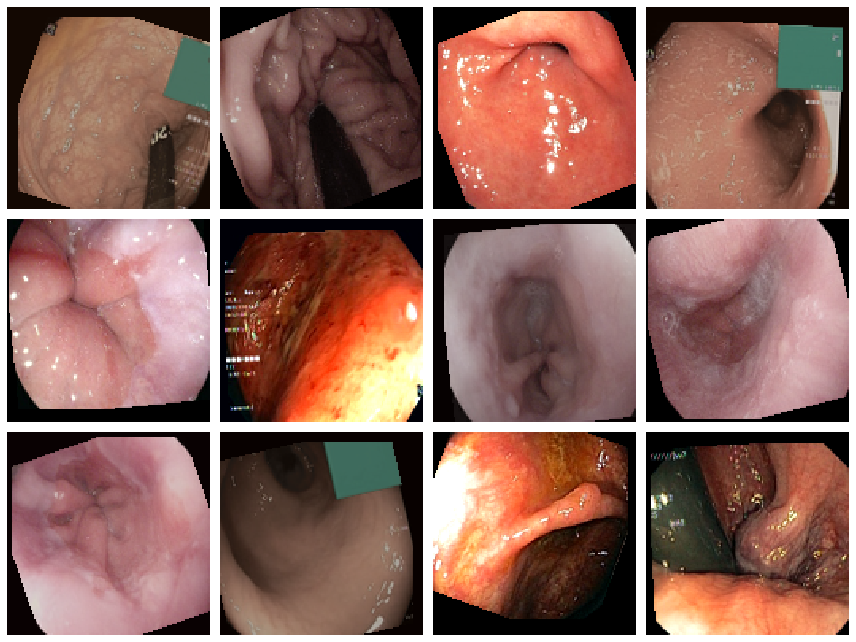

In [5]:
from utils import checkout_dataset

# Show some images from training dataset - mainly to verify augmentation and distribution
# add params for title and log_dir for savefig
checkout_dataset(train_ds)

# Step 1: Train a teacher model on labeled images

In [6]:
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers

### Create and compile the model

In [7]:
if conf["model"] == 'EfficientNetB0': 
    from efficientnet import EfficientNetB0 as EfficientNet # 5.3M params
elif conf["model"] == 'EfficientNetB1': 
    from efficientnet import EfficientNetB1 as EfficientNet # 7.8M params
elif conf["model"] == 'EfficientNetB2':
    from efficientnet import EfficientNetB2 as EfficientNet # 9.2M params
elif conf["model"] == 'EfficientNetB3':
    from efficientnet import EfficientNetB3 as EfficientNet # 12M params

Using TensorFlow backend.


In [8]:
efficientnet_base = EfficientNet(
    weights="imagenet",
    include_top=False, 
    input_shape=conf["img_shape"]
)

# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True


# Define model
teacher_model = Sequential()
teacher_model.add(efficientnet_base)
teacher_model.add(layers.GlobalAveragePooling2D())
teacher_model.add(layers.Dropout(0.3))
teacher_model.add(layers.Dense(512, activation='relu'))
teacher_model.add(layers.Dropout(0.3))
teacher_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))



# from keras import regularizers

# teacher_model = Sequential()
# teacher_model.add(efficientnet_base)
# teacher_model.add(layers.GlobalAveragePooling2D())
# teacher_model.add(layers.Dropout(0.5))
# teacher_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.5))
# teacher_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.4))
# teacher_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.3))
# teacher_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))



if conf['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
elif conf['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

teacher_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

teacher_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 4,717,235
Trainable params: 4,675,219
Non-trainable params: 42,016
_________________________________________

### Callbacks

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

# By using LearnignRateScheduler
initial_learning_rate = conf["learning_rate"]
decay_steps = params["train_size"] // conf["batch_size"]
batch_size = conf['batch_size']
decay_rate = conf['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(conf["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss', 
                              verbose=1, patience=conf["early_stopp_patience"], 
                              restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', 
                                monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if conf["early_stopp"]: callbacks.append(earlystopp_cb)
if conf["learning_schedule"]: callbacks.append(lr_schedule_cb)
if conf["checkpoint"]: callbacks.append(checkpoint_cb)

# Write conf and params dictionary to text file
list_of_strings = [ '{:20} : {}'.format(key, conf[key]) for key in conf ]
with open(log_dir+"/conf.txt","w") as f:
    [ f.write(f'{st}\n') for st in list_of_strings ]
f.close()

f = open(log_dir+"/params.txt","w")
f.write(str(params))
f.close()

#### Class weight

In [10]:
class_weights = None

if conf["class_weight"]:
    assert not conf["resample"], "Should only use resample or class_weight. Not both."
    
    from utils import calculate_weights

    class_weights = calculate_weights(
        train_ds.unbatch().take(params["train_size"]), 
        num_classes=params["num_classes"]
    )

    class_weights = dict(enumerate(class_weights))
    print ("Class weights:")
    print (class_weights)

### Train the teacher model

In [11]:
start_time = time.time()
try: 
    history = teacher_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // conf["batch_size"],
        epochs = conf["num_epochs"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // conf["batch_size"],
        validation_freq = 1,
        class_weight = class_weights,
        callbacks = callbacks,
        verbose = 1
    )
except KeyboardInterrupt:
    print ("exiting")
    
finally:
    print ("Time spent on training: {}".format(time.time() - start_time))

# Save the metrics from training
f = open(log_dir+"/history.txt","w")
f.write(str(history.history))
f.close()

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/15
58/58 [==============================] - 26s 456ms/step - loss: 2.0500 - sparse_categorical_accuracy: 0.3300 - val_loss: 2724.2892 - val_sparse_categorical_accuracy: 0.0143

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008192090395480226.
Epoch 2/15
58/58 [==============================] - 15s 255ms/step - loss: 1.3775 - sparse_categorical_accuracy: 0.4845 - val_loss: 36.9738 - val_sparse_categorical_accuracy: 0.0697

Epoch 00003: LearningRateScheduler reducing learning rate to 0.006937799043062201.
Epoch 3/15
58/58 [==============================] - 15s 264ms/step - loss: 1.0943 - sparse_categorical_accuracy: 0.5924 - val_loss: 6.7780 - val_sparse_categorical_accuracy: 0.2461

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006016597510373444.
Epoch 4/15
58/58 [==============================] - 15s 260ms/step - loss: 0.9483 - sparse_

### Save or restore a model

In [12]:
# Save the model
model_name = '{}x{}x{}_{}_{}'.format(conf["num_epochs"], conf["batch_size"], 
                                     conf["img_shape"][1], conf["ds_info"], conf["model"])
best_acc =  str(history.history["val_sparse_categorical_accuracy"][-1])[2:4]
teacher_model.save(log_dir+'/{}.h5'.format(model_name+'_'+best_acc))

## Evaluate the model

In [13]:
from model_evaluation import display_classification_report
from model_evaluation import get_metrics
from model_evaluation import get_confusion_matrix
from model_evaluation import plot_confusion_matrix

In [14]:
eval_ds = unpipe(test_ds, params["test_size"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)

true_labels = list(eval_ds[:,1])

predictions = teacher_model.predict(eval_images, verbose=1)

predicted_confidence = [np.max(pred) for pred in predictions]
predicted_labels = [np.argmax(pred) for pred in predictions]

1598/1598 [==============================] - 2s 1ms/sample


In [15]:
get_metrics(true_labels, predicted_labels)

Accuracy: 0.8273
Precision: 0.838
Recall: 0.8273
F1 Score: 0.8223


/home/henriklg/anaconda3/envs/TF2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
display_classification_report(
        true_labels, 
        predicted_labels, 
        range(params["num_classes"]), 
        target_names=params["class_names"]
)

                            precision    recall  f1-score   support

    barretts-short-segment      0.125     0.125     0.125         8
         retroflex-stomach      0.982     0.948     0.965       115
    ulcerative-colitis-0-1      0.000     0.000     0.000         5
ulcerative-colitis-grade-3      0.625     0.500     0.556        20
           esophagitis-b-d      0.941     0.410     0.571        39
    dyed-resection-margins      0.934     0.764     0.840       148
               hemorrhoids      0.000     0.000     0.000         1
             normal-z-line      0.646     0.964     0.774       140
             esophagitis-a      0.269     0.117     0.163        60
    ulcerative-colitis-1-2      0.000     0.000     0.000         2
                  barretts      0.000     0.000     0.000         6
                  bbps-2-3      0.982     0.959     0.971       172
                     ileum      0.000     0.000     0.000         1
                  bbps-0-1      0.978     0.918

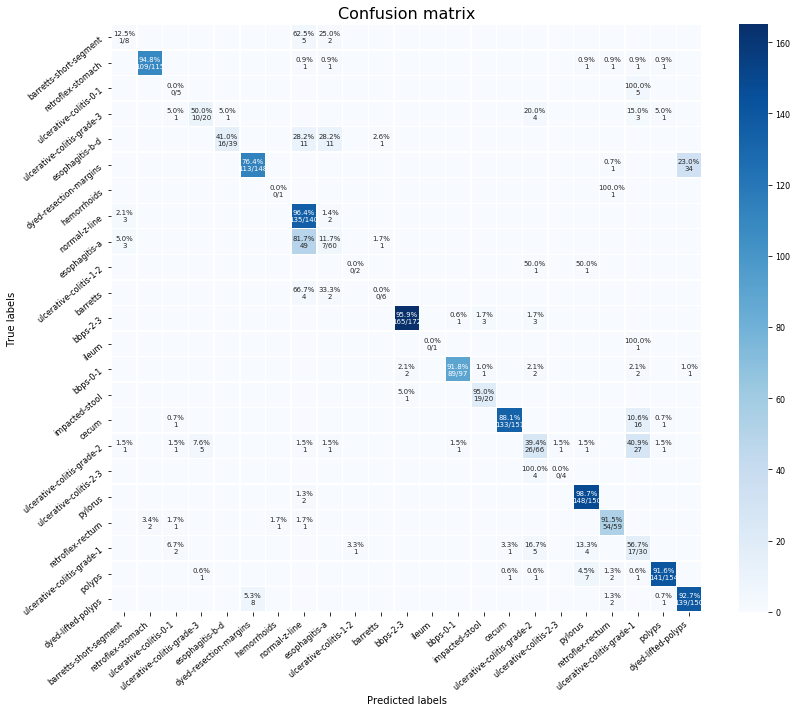

In [17]:
cm = get_confusion_matrix(true_labels, predicted_labels)
import seaborn as sns

plot_confusion_matrix(cm, log_dir, params["class_names"], figsize=(12,10))

In [18]:
# Check if validation data is cached
cache_dir = conf["cache_dir"]
img_width = conf["img_shape"][0]
ds_info = conf["ds_info"]
filename = "{}/{}_{}_val.tfcache.index".format(cache_dir, img_width, ds_info)

cached = os.path.isfile(filename)
if not cached:
    # Iterate over dataset to initialize caching
    for batch in val_ds.take( (params["val_size"]//conf["batch_size"])+1 ):
        pass

In [19]:
teacher_evaluate = teacher_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // conf["batch_size"])

# Write evaluate dictionary to text file
f = open(log_dir+"/val_evaluate.txt","w")
f.write( str(teacher_evaluate) )
f.close()

12/12 - 1s - loss: 0.4737 - sparse_categorical_accuracy: 0.8587


In [20]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if conf["learning_schedule"]: lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

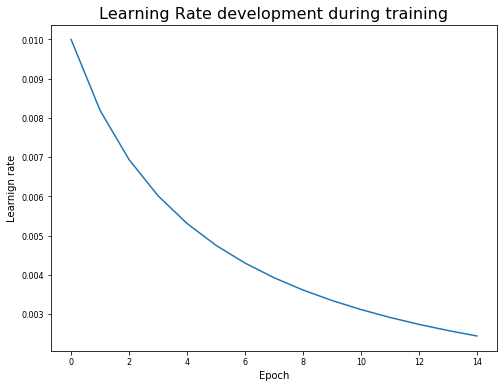

In [21]:
if conf["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.title('Learning Rate development during training');
    plt.savefig(log_dir+'/learning_rate.pdf', format='pdf')

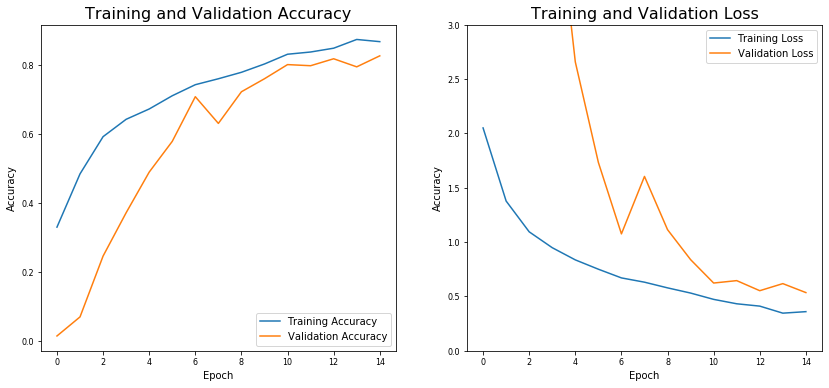

In [22]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.pdf', format='pdf')
plt.show()

Display grid of some random samples from validation data with the prediction confidence

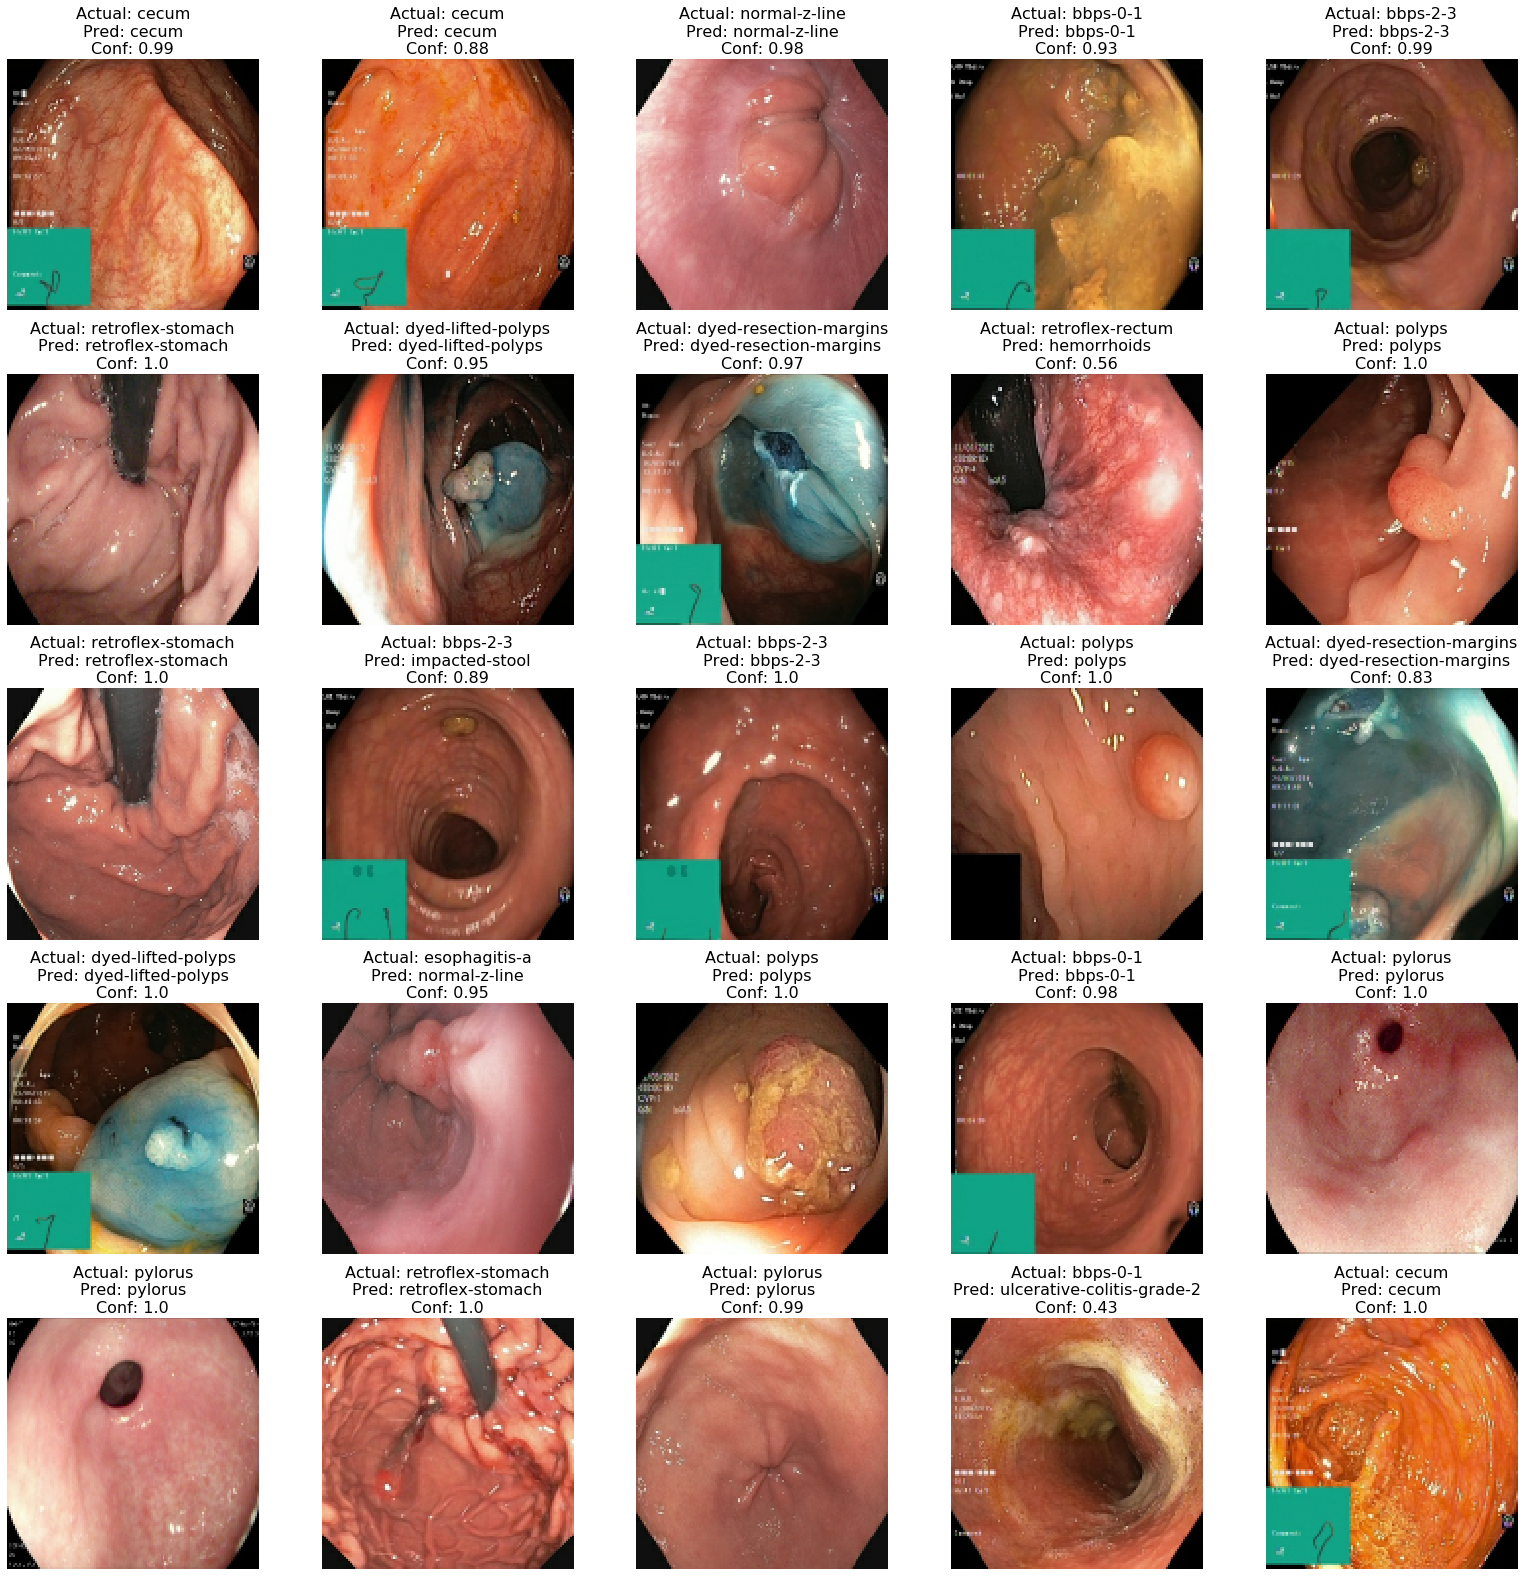

In [23]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(22, 22)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = params["class_names"][true_labels[img_idx]]
        lab = params["class_names"][predicted_labels[img_idx]]
        pred = np.round(predicted_confidence[img_idx], 2)
        
        title = 'Actual: '+actual+'\nPred: '+lab+ '\nConf: '+str(pred)
        ax[i][j].axis('off')
        ax[i][j].set_title(title)
        ax[i][j].imshow(eval_images[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.savefig(log_dir+"/model_predictions-val.pdf", format="pdf")

### Test: run prediction on images from the validation dataset

### Test: run prediction on images from the unlabeled_test dataset
(which are images taken from the training data)  
TODO: just remove this?

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Read in the unlabeled dataset

In [161]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img) # had to remove channels=3 paramter..
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [ conf["img_shape"][0], conf["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [162]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/unlabeled_ttv/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(
        files_string, 
        shuffle=conf["shuffle_buffer_size"]>1, 
        seed=tf.constant(conf["seed"], tf.int64)
)

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

print ("Loaded {} images into unlabeled_ds.".format(ds_size_unlabeled))

Loaded 99417 images into unlabeled_ds.


File: b79fd89e-6dc5-4ff9-bc5b-2da4900b8479.jpg

99.89% polyps


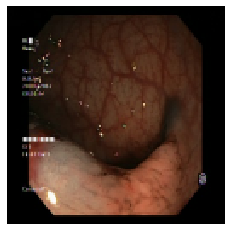

In [163]:
# Run prediction on 1 image
#img, name = next(iter(unlabeled_ds))

for img, name in unlabeled_ds.take(1):

    print ("File:",str(name.numpy())[2:-1], end='\n\n')
    show_image(img.numpy())

    # Add dimension and predict
    img = np.expand_dims(img.numpy(), 0)
    prediction = teacher_model.predict(img, verbose=0)

    # If probability above 1% print info
    for i, pred in enumerate(prediction[0]):
         if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

## Run predictions on all unlabeled images
Using 'append to list and convert to tensor'-method

In [164]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from utils import print_bar_chart

pred_confidence = 0.75
new_findings = 0
count = 0
img_list = []
lab_list = []
pred_list = []
path_list = []

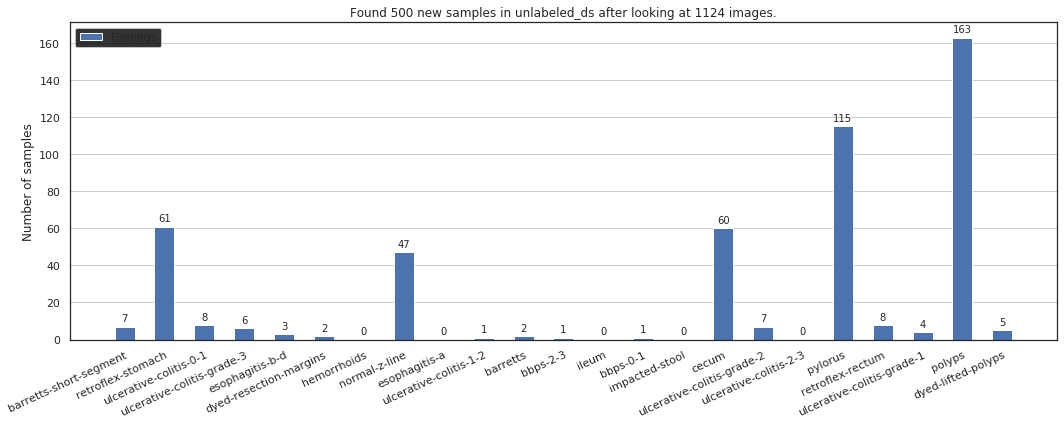

Exiting

Total run time: 33.775 s
Found 563 new samples in unlabeled_ds after looking at 1241 images.


In [165]:
total_time = time.time()

tqdm_predicting = tqdm(total=ds_size_unlabeled, desc='Predicting', position=0, initial=count)
tqdm_findings = tqdm(total=ds_size_unlabeled, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)

print ("Press 'Interrupt Kernel' to save and exit.")
try:
    for count, (image,path) in enumerate(unlabeled_ds, start=count):
        img = np.expand_dims(image, 0)
        pred = teacher_model.predict(img)
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)

            img_list.append(image)
            lab_list.append(pred_idx)
            pred_list.append(highest_pred)
            path_list.append(path)
            
            # Generate bar chart and refresh the tqdm progress bars
            if not new_findings%500:
                clear_output(wait=True)
                tqdm_predicting = tqdm(total=ds_size_unlabeled, desc='Predicting', position=0, initial=count)
                tqdm_findings = tqdm(total=ds_size_unlabeled, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)
                print_bar_chart(lab_list, new_findings, count, params)
                
            new_findings += 1
            tqdm_findings.update(1)
        tqdm_predicting.update(1)
except KeyboardInterrupt:
    print ("Exiting")

finally:
    print ("\nTotal run time: {:.3f} s".format( time.time() - total_time ))
    print ("Found {} new samples in unlabeled_ds after looking at {} images.".format(new_findings, count))

In [166]:
# Save the bar chart
print_bar_chart(lab_list, new_findings, count, params, log_dir=log_dir, figsize=(15,10))
clear_output(wait=False)

Save the image and labels list as pickle dump

## Inspect the classified images

### Sort new samples after prediction confidence

In [168]:
from utils import custom_sort

pred_list, lab_list, img_list, path_list = custom_sort(pred_list, lab_list, img_list, path_list)

### Display samples from all classes

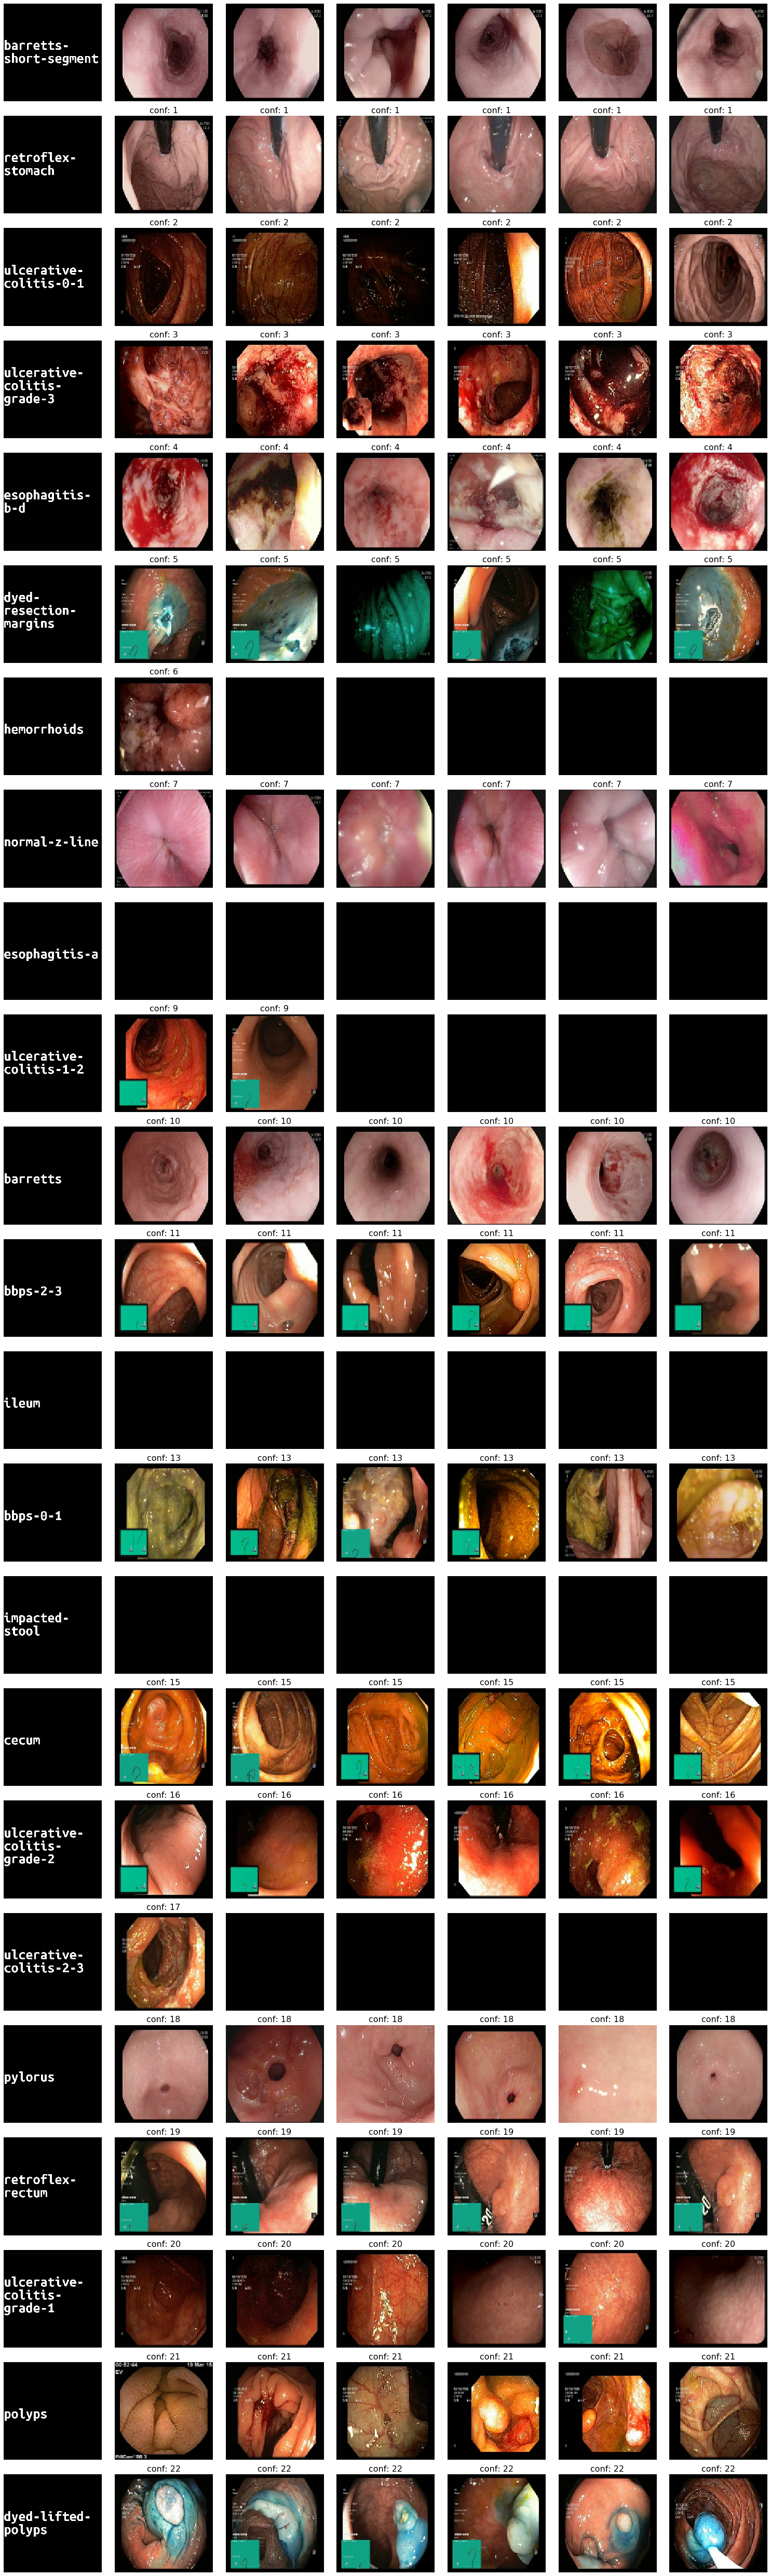

In [31]:
from utils import checkout_unlab

unlab = [pred_list, lab_list, img_list]
checkout_unlab(unlab, conf, params, log_dir)

### Print grid of images from one of the classes

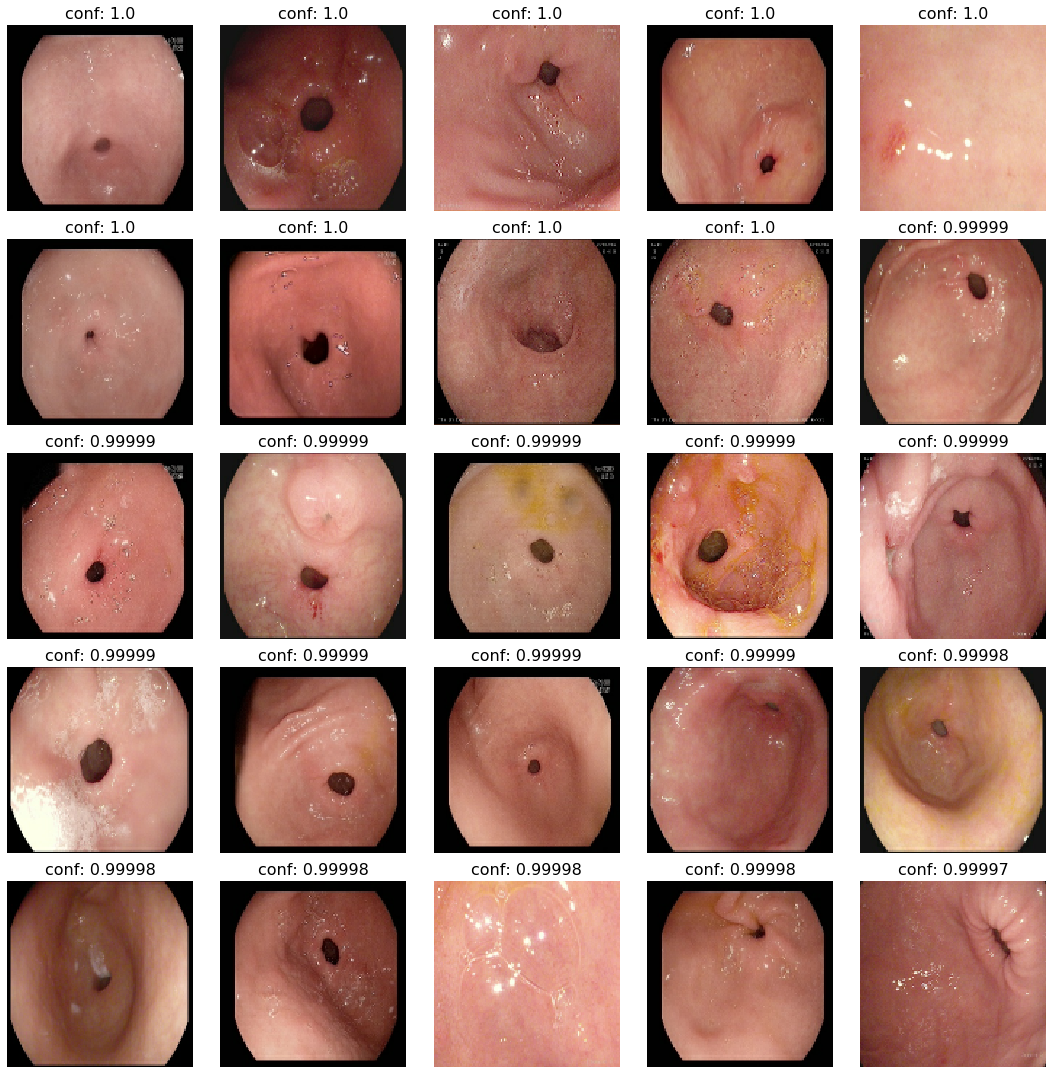

In [32]:
from utils import checkout_class

checkout_class("pylorus", unlab, conf, params, log_dir)

### Resample the new findings to "fit" original distribution of samples per class

In [169]:
# Get the _last_ distribution used for training - NB: this must be updated for each teacher/student iteration
orig_dist = params["train_dist"]

idx_to_match = np.argmax(orig_dist)
num_to_match = np.max(orig_dist)

print ("class with most samples", num_to_match)
print ("class:", params["class_names"][idx_to_match])
print ("----------------------")

new_findings = ([], [])
new_findings_filepaths = []
lab_arr = np.asarray(lab_list, dtype=np.uint8)

for class_idx in range(params["num_classes"]):
    print (params["class_names"][class_idx])
    samples_already_in_class = params["train_dist"][class_idx]
    print ("orig_dist:",samples_already_in_class)
    
    indexes = np.where(lab_arr==class_idx)[0]
    num_new_findings = len(indexes)
    print ("new findings in unlab:", num_new_findings)
    
    if num_new_findings == 0:
        print ("No samples in this class")
    
    
    in_count = samples_already_in_class
    # check if samples should be added
    
    count = 0
    for count, idx in enumerate(indexes, start=1):
        if in_count >= num_to_match:
            break
        new_findings[0].append(img_list[idx])   # image
        new_findings[1].append(lab_list[idx])   # label
        new_findings_filepaths.append(path_list[idx]) # filepath
        in_count += 1
    print ("added {} samples.".format(count))
    print ()

class with most samples 803.0
class: bbps-2-3
----------------------
barretts-short-segment
orig_dist: 37.0
new findings in unlab: 8
added 8 samples.

retroflex-stomach
orig_dist: 534.0
new findings in unlab: 70
added 70 samples.

ulcerative-colitis-0-1
orig_dist: 24.0
new findings in unlab: 9
added 9 samples.

ulcerative-colitis-grade-3
orig_dist: 93.0
new findings in unlab: 6
added 6 samples.

esophagitis-b-d
orig_dist: 182.0
new findings in unlab: 3
added 3 samples.

dyed-resection-margins
orig_dist: 692.0
new findings in unlab: 2
added 2 samples.

hemorrhoids
orig_dist: 4.0
new findings in unlab: 0
No samples in this class
added 0 samples.

normal-z-line
orig_dist: 652.0
new findings in unlab: 50
added 50 samples.

esophagitis-a
orig_dist: 282.0
new findings in unlab: 0
No samples in this class
added 0 samples.

ulcerative-colitis-1-2
orig_dist: 7.0
new findings in unlab: 1
added 1 samples.

barretts
orig_dist: 28.0
new findings in unlab: 2
added 2 samples.

bbps-2-3
orig_dist: 803

In [172]:
for i, path in enumerate(new_findings_filepaths):
    if i > 10:
        break
    print (path)

tf.Tensor(b'b2142f34-925c-49bd-8657-18d7c4000fae.jpg', shape=(), dtype=string)
tf.Tensor(b'f04a8817-0527-4dea-b369-9cbb80a36a66.jpg', shape=(), dtype=string)
tf.Tensor(b'eb244706-d583-435f-882e-95c9a46dd2ee.jpg', shape=(), dtype=string)
tf.Tensor(b'0d1c7e35-53ec-4462-b98f-a420e11c8de0.jpg', shape=(), dtype=string)
tf.Tensor(b'34e22da7-18be-4292-a11b-18a3639470b7.jpg', shape=(), dtype=string)
tf.Tensor(b'3a1dfb41-507e-4fe8-8817-ff8c9d5d1de0.jpg', shape=(), dtype=string)
tf.Tensor(b'3810cefe-372c-42ec-8467-cbd5211c38f7.jpg', shape=(), dtype=string)
tf.Tensor(b'34da7f40-f197-4293-917d-8e2cf12412f8.jpg', shape=(), dtype=string)
tf.Tensor(b'f8105551-721f-46b6-ba96-c1ddb6992211.jpg', shape=(), dtype=string)
tf.Tensor(b'ba8d5914-15af-4853-ab34-339b39163dcd.jpg', shape=(), dtype=string)
tf.Tensor(b'54273d6d-08ed-4863-b4f0-4c2a1ae18daf.jpg', shape=(), dtype=string)


### Convert image and label lists to tensors and combine with training_ds to create a new dataset for training

In [173]:
print ("original train size:", params["train_size"])

added_findings = len(new_findings[1])
print ("added findings:", added_findings)

new_train_size = params["train_size"]+added_findings
print ("new train size:", new_train_size)

original train size: 7454
added findings: 437
new train size: 7891


In [174]:
findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)

In [175]:
distx, countx = class_distribution(clean_train, 23)
print (distx)
print (countx)

[0.00496378 0.07163939 0.00321975 0.01247652 0.02441642 0.09283606
 0.00053662 0.08746982 0.03783204 0.00093909 0.00375637 0.10772739
 0.00080494 0.06063858 0.01220821 0.09471425 0.04158841 0.00254897
 0.09377515 0.03662463 0.01878186 0.09645828 0.09404346]
[ 37. 534.  24.  93. 182. 692.   4. 652. 282.   7.  28. 803.   6. 452.
  91. 706. 310.  19. 699. 273. 140. 719. 701.]


In [176]:
# combine with old ds
combined_ds = clean_train.concatenate(findings_tensor)

In [177]:
disty, county = class_distribution(combined_ds, 23)
print (disty)
print (county)

[0.0057027  0.0765429  0.00418198 0.01254594 0.02344443 0.08794829
 0.00050691 0.08896211 0.03573691 0.00101381 0.0038018  0.1017615
 0.00076036 0.05740717 0.01153213 0.09808642 0.04055253 0.00240781
 0.1017615  0.03573691 0.01837537 0.1017615  0.08946902]
[ 45. 604.  33.  99. 185. 694.   4. 702. 282.   8.  30. 803.   6. 453.
  91. 774. 320.  19. 803. 282. 145. 803. 706.]


Heatmap of class distribution

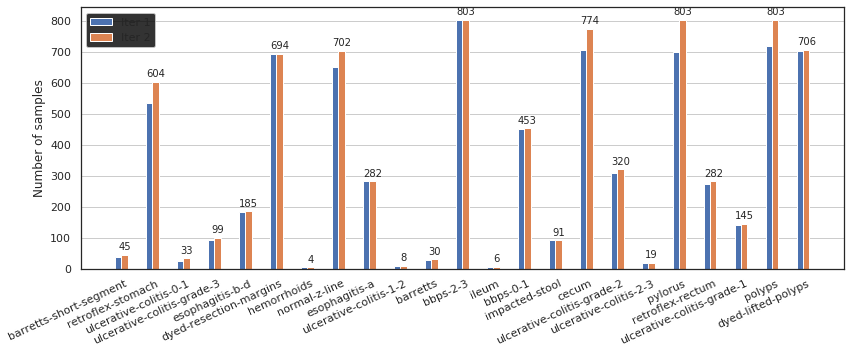

In [179]:
data1 = countx
data2 = county
data3 = countx

x = np.arange(23)
width = 0.2

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x-width, data1, width, label='Iter 1')
rects2 = ax.bar(x, data2, width, label='Iter 2')
# rects3 = ax.bar(x+width, data3, width, label='Iter 3')

ax.set_ylabel('Number of samples')
# title_string = ""
# ax.set_title(title_string)
ax.set_xticks(x)
ax.set_xticklabels(params["class_names"])
ax.set_axisbelow(True)
ax.legend();

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
             rotation_mode="anchor")
plt.grid(axis='y')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()
if log_dir:
    plt.savefig(log_dir+'/distribution_bar_chart.pdf', format='pdf')
plt.show()

### 'Refresh' unlabeled dataset by extracting samples already used

In [130]:
used_paths = []

for img, path in unlabeled_ds.repeat().take(20):
    used_paths.append(path.numpy().decode('utf-8'))

In [143]:
# convert to tensor
used_paths_tensor = tf.convert_to_tensor(used_paths)

In [181]:
used_paths_tensor?

Type:            EagerTensor
String form:    
tf.Tensor(
           [b'0ae7837d-e8f6-4121-b3db-f31a0a467acfesophagitis-a.jpg'
           b'0d0c8784-f7af-4d00-a1db-6 <...> is-grade-3.jpg'
           b'1ba881b6-36de-4e9f-8867-ac9bded80858barretts.jpg'], shape=(20,), dtype=string)
Length:          20
File:            ~/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py
Docstring:       <no docstring>
Class docstring: Base class for EagerTensor.


In [159]:
def remove_samples(img, path):
    bool_list = tf.equal(path, used_paths_tensor)
    in_list = tf.math.count_nonzero(bool_list) > 0
    return not in_list

new_unlabeled = unlabeled_ds.filter(remove_samples)
# new_unlabeled = unlabeled_ds.filter(tf.py_function(remove_samples, inp, out))

In [180]:
new_findings_filepaths?

Type:        list
String form: [<tf.Tensor: shape=(), dtype=string, numpy=b'b2142f34-925c-49bd-8657-18d7c4000fae.jpg'>, <tf.Tens <...> 0e.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cf6e0bdc-c4ff-4b09-b242-2d7edcfc412a.jpg'>]
Length:      437
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.


In [182]:
def remove_samples(img, path):
    bool_list = tf.equal(path, new_findings_filepaths)
    in_list = tf.math.count_nonzero(bool_list) > 0
    return not in_list

new_unlabeled = unlabeled_ds.filter(remove_samples)
# new_unlabeled = unlabeled_ds.filter(tf.py_function(remove_samples, inp, out))

In [183]:
for i, (img, path) in enumerate(new_unlabeled):
    pass

print (i)

98979


# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [ ]:
combined_ds = prepare_for_training(
        combined_ds, 
        conf["batch_size"], 
        cache=None,
        shuffle_buffer_size=0
    )

In [ ]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
stud_model = Sequential()
stud_model.add(efficientnet_base)
stud_model.add(layers.GlobalAveragePooling2D())
# add Dense layer and dropout?
stud_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))

if conf['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
elif conf['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

stud_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
history = stud_model.fit(
    combined_ds,
    steps_per_epoch = params["train_size"]+new_samples_counter // conf["batch_size"], # might have to reduce
    epochs = 2,
    validation_data = test_ds, # what to use for validation data?
    validation_steps = params["test_size"] // conf["batch_size"],
    validation_freq = 1,
    callbacks = callbacks
)

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student